In [43]:
import os
import netCDF4
import numpy as np
from datetime import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML

from scipy import ndimage
from skimage import morphology, measure, feature
from sklearn.decomposition import PCA

In [21]:
input_path  = '/g/data/kl02/jss548/bonn-project-data/radolan_data/radolan_nc'
output_path = '/g/data/kl02/jss548/bonn-project-data/radolan_png'
bad         = np.nan
min_value   = -32.5
x_start     = 145 #values in x dim less this this aren't present
input_fn    = 'RX-2013-08-06.nc'

In [22]:
#read nc file
input_ffn = os.path.join(input_path, input_fn)
with netCDF4.Dataset(input_ffn) as ncid:
    refl_data = np.squeeze(ncid['rx'][:, :, :]).filled(min_value)
    time_list = np.squeeze(ncid['time'][:])
    time_units = ncid.variables['time'].units

In [23]:
#calculate convolutions
def refl_to_int(ref):
    return np.floor(ref/5)*5

n         = 2
pad_value = np.floor(min_value/5)*5
g1_size   = 2*n + 1
g2_size   = 4*n + 3
min_refl  = 0.
max_refl  = 30.

kernel_dilate = np.ones((3,3),np.uint8)
kernel_erode  = np.ones((3,3),np.uint8)
kernel_open   = np.ones((3,3),np.uint8)

In [57]:
def animate_detection(i):

    """
    input: 1 (int)
        timestep integer for radar data
    
    """
    
    print('processing timestep', time_list[i])
    
    #extract refl data
    refl_img_all = refl_data[i+200, :,:]
    #crop to valid data
    refl_img_crop = refl_img_all[:, x_start:]
    refl_img = refl_img_crop.copy() + 5 #offset by +5
    refl_img[refl_img>30] = 30
    refl_img[refl_img<0] = 0

    #precip dilation
    refl_img_maxfilter = ndimage.filters.maximum_filter(refl_img, size=3, cval=0)

    #uniform filter
    unifilt_array_1 = ndimage.uniform_filter(refl_img, size=7, mode='constant', cval=0)
    unifilt_array_2 = ndimage.uniform_filter(refl_img, size=15, mode='constant', cval=0)
    ridges_map      = refl_img_maxfilter.copy() - unifilt_array_2

    #binary conversion
    ridges_map[ridges_map<0] = 0
    ridges_map_binary = ridges_map>2.5

    #erode by 1 pixel to reverse effects of 3 pixel maximum_filter
    ridges_map_binary_erosion = morphology.binary_erosion(ridges_map_binary)

    #skeleton
    skeleton = morphology.thin(ridges_map_binary_erosion)

    #remove intersection pixels

    #########################################
    ##should be possible to simplify this section
    #generate local sum to check for connected pixels
    intersection_conv = ndimage.convolve(skeleton.astype(float), np.ones((3,3)), mode='constant', cval=0)
    #mask using skeleton
    intersection_conv[skeleton==False] = 0
    #find highly connected pixels
    [xsec_i, xsec_j] = np.where(intersection_conv>3)
    #for each possible intersection
    for idx,_ in enumerate(xsec_i):
        #extract subset
        subset = skeleton.copy()[xsec_i[idx]-1:xsec_i[idx]+2, xsec_j[idx]-1:xsec_j[idx]+2]
        #set middle to be null (removing element in questions)
        subset[1,1] = False
        #check for connectivity using 4 neighbour region
        _, n_features = morphology.label(subset, neighbors=4, background=False, return_num=True, connectivity=None)
        #for more than 2 feature, remove, confirm intersection
        if n_features>2:
            skeleton[xsec_i[idx],xsec_j[idx]] = 0
    #######################################################

    #label image and remove by pixel count and 95th percentile
    label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
    for label_idx in np.arange(1,n_features):

        #filter by length
        label_count = np.sum([label_image==label_idx])
        if label_count<15:
            skeleton[label_image == label_idx] = False
            continue
            
        #calculate PCA for line
        i_idx, j_idx = np.where(label_image==label_idx)

        line_points  = np.column_stack((i_idx, j_idx))
        pca = PCA(n_components=2).fit(line_points)
        feature_vectors = pca.components_.T
        nvec            = feature_vectors[1]

        line_refl     = refl_img_crop[i_idx, j_idx]
        forward_refl  = np.zeros_like(line_refl)
        backward_refl = np.zeros_like(line_refl)

        forward_dist  = np.array([2., 3., 4., 5.])
        backward_dist = np.array([-5, -4, -3, -2])

        #for every point on the line
        for m,_ in enumerate(i_idx):

            #calculate index of forward and backward normal samples
            forward_i,  forward_j  = i_idx[m]+nvec[0]*forward_dist, j_idx[m]+nvec[1]*forward_dist
            backward_i, backward_j = i_idx[m]+nvec[0]*backward_dist, j_idx[m]+nvec[1]*backward_dist

            #extract reflectivity and take mean
            try:
                forward_refl[m]  = np.nanmean(refl_img_crop[forward_i.astype(int),  forward_j.astype(int)])
                backward_refl[m] = np.nanmean(refl_img_crop[backward_i.astype(int),  backward_j.astype(int)])
            except:
                #print('normal sampling outside of image')
                continue

        #compute means
        line_refl_mean     = np.nanmean(line_refl)
        forward_refl_mean  = np.nanmean(forward_refl)
        backward_refl_mean = np.nanmean(backward_refl)

        #mask if not true ridge
        if line_refl_mean-forward_refl_mean<2.5 or line_refl_mean-backward_refl_mean<2.5:
            skeleton[label_image == label_idx] = False
            continue        


        refl_prec = np.percentile(line_refl, 95)
        if refl_prec > 20:
            skeleton[label_image == label_idx] = False
            continue


    #plotting
    plt.clf()
    #fig = plt.figure(facecolor='white', figsize=(40, 20))

    ax0 = plt.subplot(1,2,1)
    im0 = ax0.imshow(refl_img_crop)
    ax0.set_title('Intensity Reduced Reflectivity')
    fig.colorbar(im0, ax=ax0)
    # axarr[0].set_ylim([400, 500])
    # axarr[0].set_xlim([600, 700])

    ax1 = plt.subplot(1,2,2)
    im1 = ax1.imshow(refl_img_crop)
    [boundary_i, boundary_j] = np.where(skeleton)
    ax1.plot(boundary_j, boundary_i, 'w.', markersize=0.5)
    ax1.set_title('clutter')
    fig.colorbar(im1, ax=ax1)
    # axarr[1].set_ylim([400, 500])
    # axarr[1].set_xlim([600, 700])

    #plt.savefig('test.png', dpi=200)

In [58]:
fig = plt.figure(figsize=(20, 10))

ani_object = ani.FuncAnimation(fig, animate_detection, frames=10)

#Save animation to gif
anim_name = 'dbzh_animation_' + dt.now().strftime('%H%M%S') +'.gif'
ani_object.save(anim_name,
          writer='imagemagick', fps=5)
plt.close()
#show gif in notebook
print('complete')
HTML('<img src="' + anim_name + '">')

processing timestep 1375747200.0
processing timestep 1375747200.0
processing timestep 1375747500.0
processing timestep 1375747800.0
processing timestep 1375748100.0
processing timestep 1375748400.0
processing timestep 1375748700.0
processing timestep 1375749000.0
processing timestep 1375749300.0
processing timestep 1375749600.0
processing timestep 1375749900.0
complete


processing timestep 1375805700.0


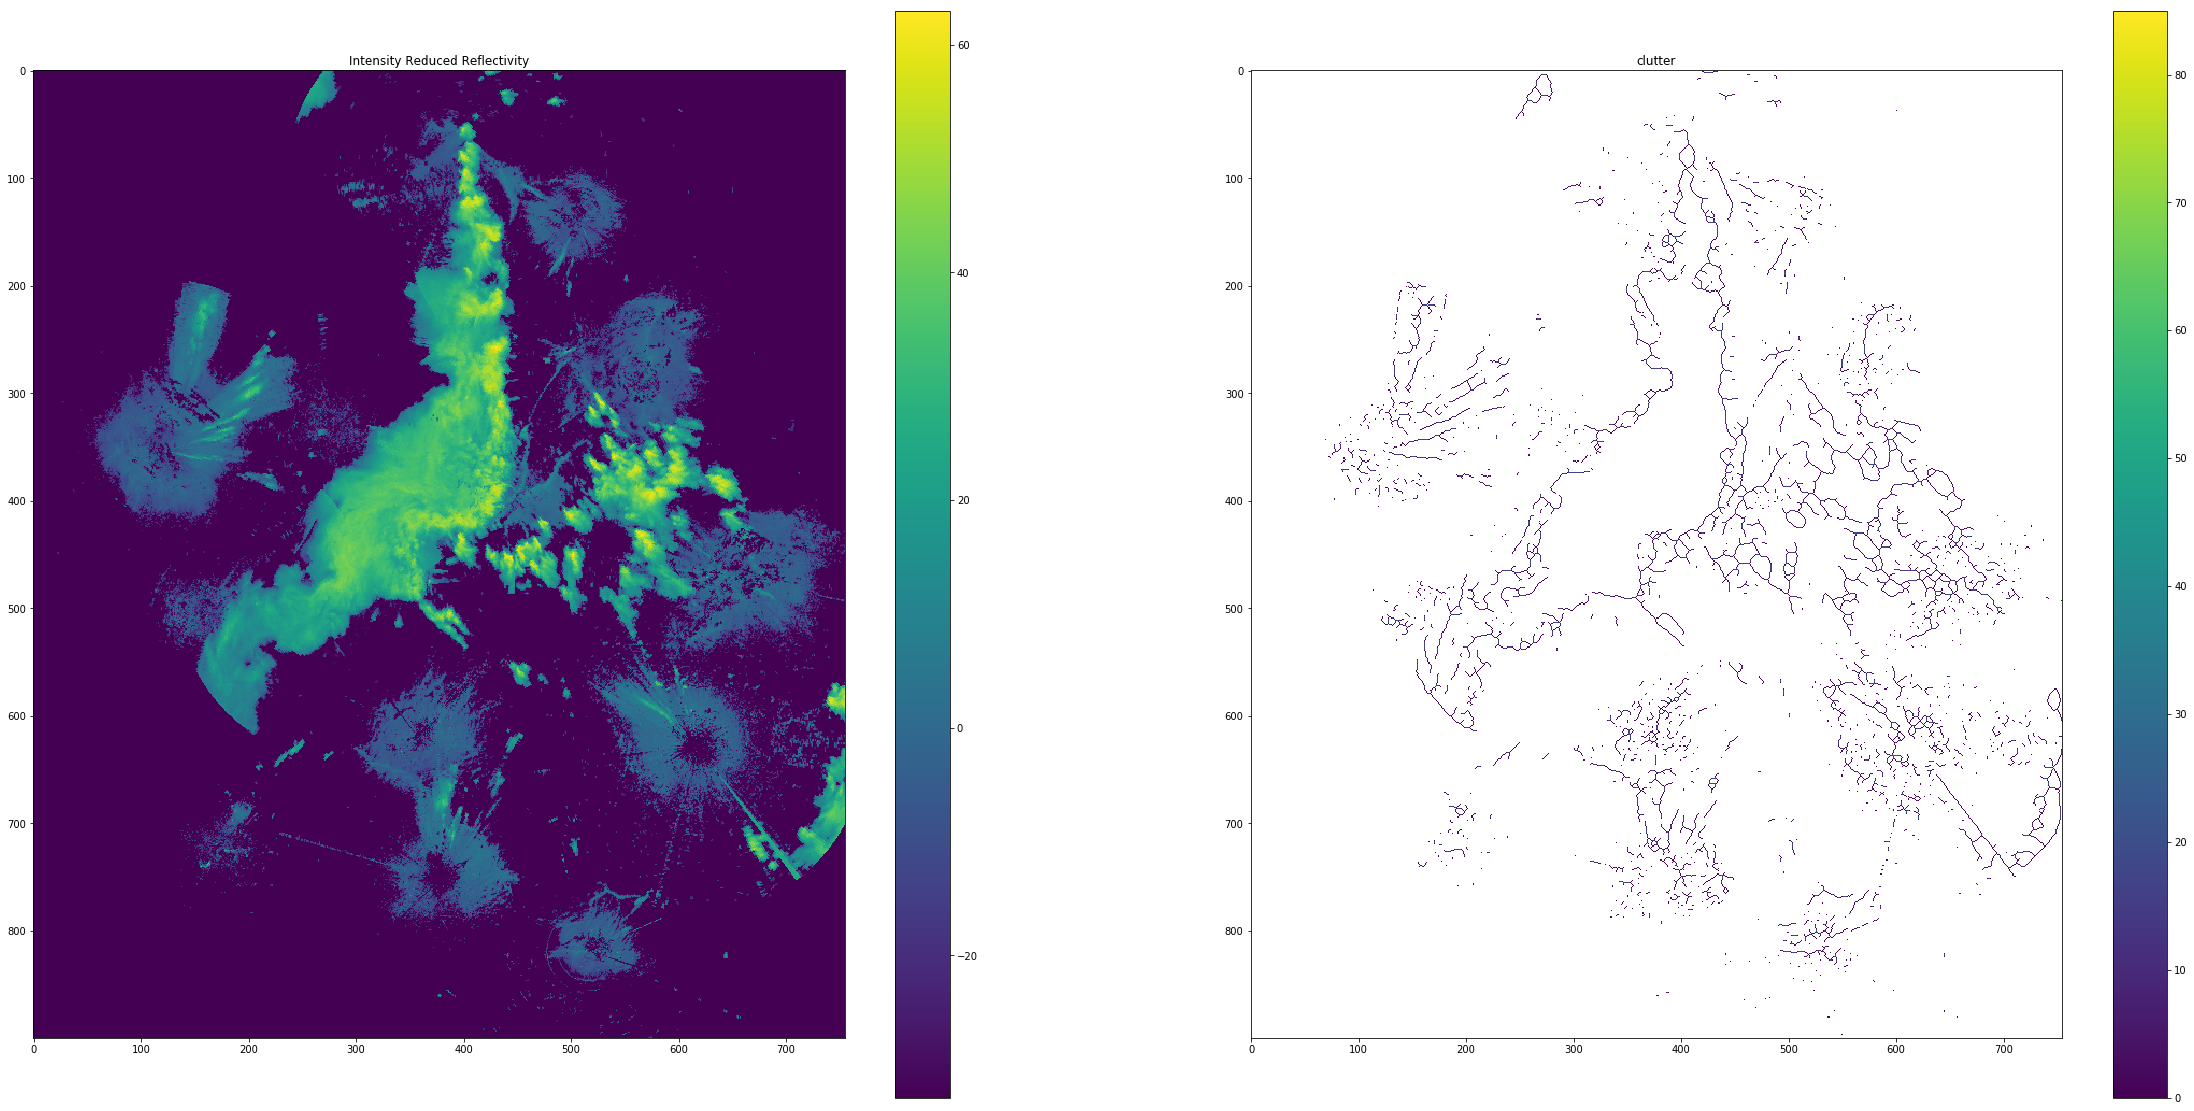

In [49]:
timestep = 195
print('processing timestep', time_list[timestep])
    
#extract refl data
refl_img_all = refl_data[timestep, :,:]
#crop to valid data
refl_img_crop = refl_img_all[:, x_start:]
refl_img = refl_img_crop.copy() + 5 #offset by +5
refl_img[refl_img>30] = 30
refl_img[refl_img<0] = 0

#precip dilation
refl_img_maxfilter = ndimage.filters.maximum_filter(refl_img, size=3, cval=0)

#uniform filter
unifilt_array_1 = ndimage.uniform_filter(refl_img, size=7, mode='constant', cval=0)
unifilt_array_2 = ndimage.uniform_filter(refl_img, size=15, mode='constant', cval=0)
ridges_map      = refl_img_maxfilter.copy() - unifilt_array_2

#binary conversion
ridges_map[ridges_map<0] = 0
ridges_map_binary = ridges_map>2.5

#erode by 1 pixel to reverse effects of 3 pixel maximum_filter
ridges_map_binary_erosion = morphology.binary_erosion(ridges_map_binary)

#skeleton
skeleton = morphology.thin(ridges_map_binary_erosion)

#filter 2: split intersections
lbp = feature.local_binary_pattern(skeleton, 8, 1, method='ror')


# #remove intersection pixels

# #########################################
# ##should be possible to simplify this section
# #generate local sum to check for connected pixels
# intersection_conv = ndimage.convolve(skeleton.astype(float), np.ones((3,3)), mode='constant', cval=0)
# #mask using skeleton
# intersection_conv[skeleton==False] = 0
# #find highly connected pixels
# [xsec_i, xsec_j] = np.where(intersection_conv>3)
# #for each possible intersection
# for idx,_ in enumerate(xsec_i):
#     #extract subset
#     subset = skeleton.copy()[xsec_i[idx]-1:xsec_i[idx]+2, xsec_j[idx]-1:xsec_j[idx]+2]
#     #set middle to be null (removing element in questions)
#     subset[1,1] = False
#     #check for connectivity using 4 neighbour region
#     _, n_features = morphology.label(subset, neighbors=4, background=False, return_num=True, connectivity=None)
#     #for more than 2 feature, remove, confirm intersection
#     if n_features>2:
#         skeleton[xsec_i[idx],xsec_j[idx]] = 0
# #######################################################

# #label image and remove by pixel count and 95th percentile
# label_image, n_features = morphology.label(skeleton, neighbors=8, background=False, return_num=True, connectivity=1)
# for label_idx in np.arange(1,n_features):

#     #filter 1: by length
#     label_count = np.sum([label_image==label_idx])
#     if label_count<15:
#         skeleton[label_image == label_idx] = False
#         continue
        
#     #calculate PCA for line
#     i_idx, j_idx = np.where(label_image==label_idx)

#     line_points  = np.column_stack((i_idx, j_idx))
#     pca = PCA(n_components=2).fit(line_points)
#     feature_vectors = pca.components_.T
#     nvec            = feature_vectors[1]

#     line_refl     = refl_img_crop[i_idx, j_idx]
#     forward_refl  = np.zeros_like(line_refl)
#     backward_refl = np.zeros_like(line_refl)

#     forward_dist  = np.array([2., 3., 4., 5.])
#     backward_dist = np.array([-5, -4, -3, -2])

#     #for every point on the line
#     for m,_ in enumerate(i_idx):

#         #calculate index of forward and backward normal samples
#         forward_i,  forward_j  = i_idx[m]+nvec[0]*forward_dist, j_idx[m]+nvec[1]*forward_dist
#         backward_i, backward_j = i_idx[m]+nvec[0]*backward_dist, j_idx[m]+nvec[1]*backward_dist

#         #extract reflectivity and take mean
#         try:
#             forward_refl[m]  = np.nanmean(refl_img_crop[forward_i.astype(int),  forward_j.astype(int)])
#             backward_refl[m] = np.nanmean(refl_img_crop[backward_i.astype(int),  backward_j.astype(int)])
#         except:
#             #print('normal sampling outside of image')
#             continue

#     #compute means
#     line_refl_mean     = np.nanmean(line_refl)
#     forward_refl_mean  = np.nanmean(forward_refl)
#     backward_refl_mean = np.nanmean(backward_refl)

#     #mask if not true ridge
#     if line_refl_mean-forward_refl_mean<0 or line_refl_mean-backward_refl_mean<0:
#         skeleton[label_image == label_idx] = False
#         continue        


#         refl_prec = np.percentile(line_refl, 95)
#         if refl_prec > 20:
#             skeleton[label_image == label_idx] = False
#             continue


#plotting
fig = plt.figure(facecolor='white', figsize=(40, 20))

ax0 = plt.subplot(1,2,1)
im0 = ax0.imshow(refl_img_crop)
ax0.set_title('Intensity Reduced Reflectivity')
fig.colorbar(im0, ax=ax0)
# axarr[0].set_ylim([400, 500])
# axarr[0].set_xlim([600, 700])

ax1 = plt.subplot(1,2,2)
lbp[lbp==255] = np.nan
im1 = ax1.imshow(lbp)
# [boundary_i, boundary_j] = np.where(skeleton)
# ax1.plot(boundary_j, boundary_i, 'w.', markersize=1.0)
ax1.set_title('clutter')
fig.colorbar(im1, ax=ax1)
# axarr[1].set_ylim([400, 500])
# axarr[1].set_xlim([600, 700])

plt.savefig('test.png', dpi=200)

In [72]:
#filter 2: split intersections
test = np.array([[0,0,0],
                 [0,1,1],
                 [0,0,0]])
lbp = feature.local_binary_pattern(test, 8, 1, method='default')
print(lbp)

[[255. 255. 255.]
 [255.   1.  16.]
 [255. 255. 255.]]
